# 4D reconstruction using beam images on the target

In [1]:
import sys
import os
from os.path import join

import numpy as np
import pandas as pd
from skimage import transform
from scipy import ndimage
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import animation
import proplot as pplt
import importlib
from tqdm import tqdm
from tqdm import trange

sys.path.append('/Users/46h/Research/')
from scdist.tools import ap_utils
from scdist.tools import beam_analysis as ba
from scdist.tools import plotting as myplt
from scdist.tools import utils
from scdist.measurement import tis
from scdist.measurement.tomography import reconstruct as rec

In [2]:
pplt.rc['animation.html'] = 'jshtml'
pplt.rc['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'mono_r'
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['grid'] = False
pplt.rc['grid.alpha'] = 0.04
pplt.rc['savefig.transparent'] = True
pplt.rc['savefig.dpi'] = 'figure'
savefig_kws = dict(dpi=350)

## Optics

In [3]:
folder = '_output/data/'
filenames = utils.list_files(folder)

### Phase advances 

In [4]:
phase_adv = np.loadtxt(join(folder, 'phase_adv.dat'))
phase_adv_exp = np.loadtxt(join(folder, 'phase_adv_exp.dat'))
steps_per_dim = int(np.sqrt(len(phase_adv)))

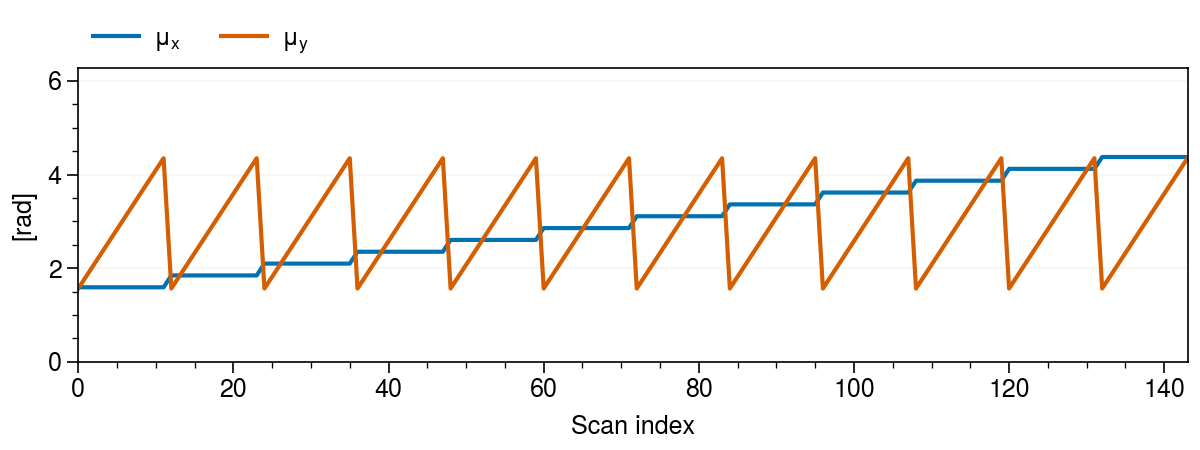

In [5]:
fig, ax = pplt.subplots(figsize=(6, 2.25))
g1 = ax.plot(phase_adv[:, 0], marker='.', ms=0)
g2 = ax.plot(phase_adv[:, 1], marker='.', ms=0)
ax.legend([g1, g2], labels=[r"$\mu_x$", r"$\mu_y$"], loc=(0., 1.), framealpha=0.)
ax.format(ylabel='[rad]', xlabel='Scan index', ylim=(0., 2*np.pi), ygrid=True)
plt.savefig('_output/figures/phase_adv.png', **savefig_kws)
plt.show()

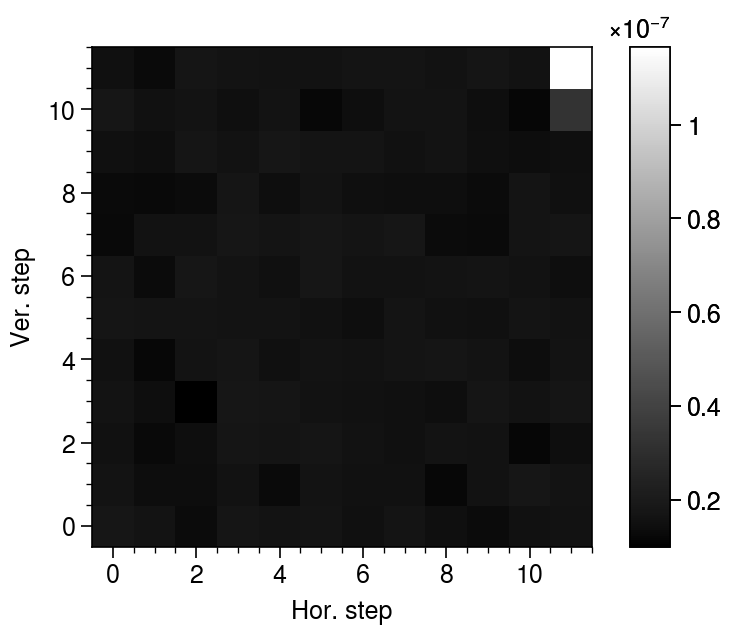

In [6]:
phase_adv_error = np.sqrt(np.sum((phase_adv_exp - phase_adv)**2, axis=1))
phase_adv_error = phase_adv_error.reshape((steps_per_dim, steps_per_dim))

fig, ax = pplt.subplots()
ax.pcolormesh(phase_adv_error.T, colorbar=True)
ax.format(xlabel='Hor. step', ylabel='Ver. step')
plt.show()

### Twiss parameters vs. position

In [7]:
filenames = utils.list_files(folder)
twiss_filenames = [f for f in filenames if 'twiss' in f and 'default' not in f]
twiss_filenames = sorted(twiss_filenames, 
                         key=lambda f: float(f.split('.')[0].split('_')[-1]))
twiss_list = np.array([np.loadtxt(f) for f in twiss_filenames])

In [8]:
plot_kws = dict(alpha=0.1, marker=None, lw=0.75)
i = 210
colors = myplt.DEFAULT_COLORCYCLE

# fig, ax = pplt.subplots(figsize=(5.0, 3.0))
# for twiss in twiss_list:
#     positions, mux, muy, alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = twiss[i:].T
#     ax.plot(positions, beta_x, color=colors[0], **plot_kws)
#     ax.plot(positions, beta_y, color=colors[1], **plot_kws)
# ax.format(ylabel='[m/rad]', ylim=(0., 100.), xlabel='Position [m]', ygrid=False)

# lines = [Line2D([0], [0], color=colors[0]), Line2D([0], [0], color=colors[1])]
# ax.legend(lines, [r"$\beta_x$", r"$\beta_y$"], loc=(0., 1.), framealpha=0.)
# plt.savefig('_output/figures/beta_vs_pos.png', **savefig_kws)
# plt.show()

In [9]:
# fig, ax = pplt.subplots(figsize=(6, 2.25))
# for twiss in twiss_list:
#     positions, mu_x, mu_y, alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = twiss[i:].T
#     ax.plot(positions, mu_x, color=colors[0], **plot_kws)
#     ax.plot(positions, mu_y, color=colors[1], **plot_kws)
# ax.format(ylabel='[rad]', xlabel='Position [m]', ylim=(0., 2*np.pi), ygrid=False)

# lines = [Line2D([0], [0], color=colors[0]), Line2D([0], [0], color=colors[1])]
# ax.legend(lines, [r"$\mu_x$", r"$\mu_y$"], loc=(0., 1.), framealpha=0.)
# plt.savefig('_output/figures/phase_adv_vs_pos.png', **savefig_kws)
# plt.show()

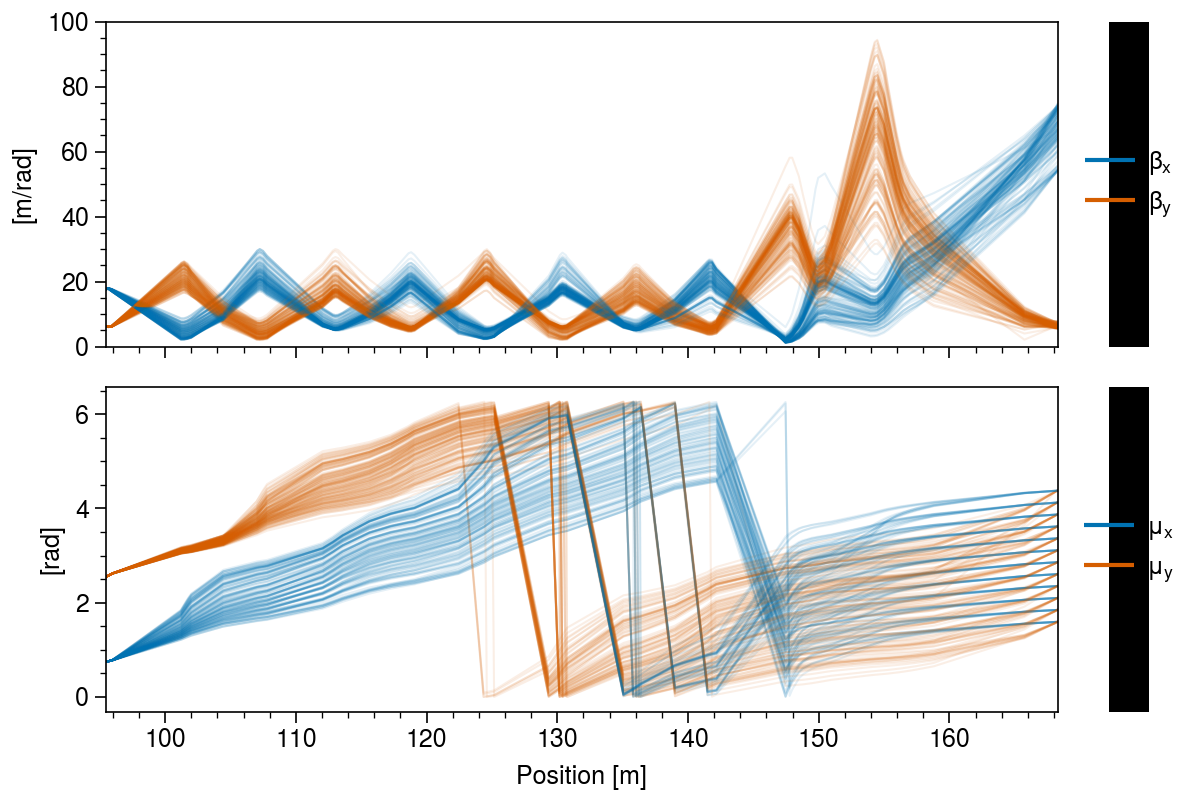

In [10]:
fig, axes = pplt.subplots(nrows=2, figsize=(6.0, 4.0), spany=False)
for twiss in twiss_list:
    positions, mux, muy, alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = twiss[i:].T
    axes[0].plot(positions, beta_x, color=colors[0], **plot_kws)
    axes[0].plot(positions, beta_y, color=colors[1], **plot_kws)
    axes[1].plot(positions, mux, color=colors[0], **plot_kws)
    axes[1].plot(positions, muy, color=colors[1], **plot_kws)
axes[0].format(ylabel='[m/rad]', ylim=(0., 100.), xlabel='Position [m]')
axes[1].format(ylabel='[rad]', xlabel='Position [m]')

lines = [Line2D([0], [0], color=colors[0]), Line2D([0], [0], color=colors[1])]
axes[0].legend(lines, [r"$\beta_x$", r"$\beta_y$"], loc='r', ncols=1, framealpha=0.)
axes[1].legend(lines, [r"$\mu_x$", r"$\mu_y$"], loc='r', ncols=1, framealpha=0.)
plt.savefig('_output/figures/beta_and_phase_vs_pos.png', **savefig_kws)
plt.show()

### Quadrupole field strengths 

In [11]:
fields = pd.read_table(join(folder, 'fields.dat'), sep=' ')

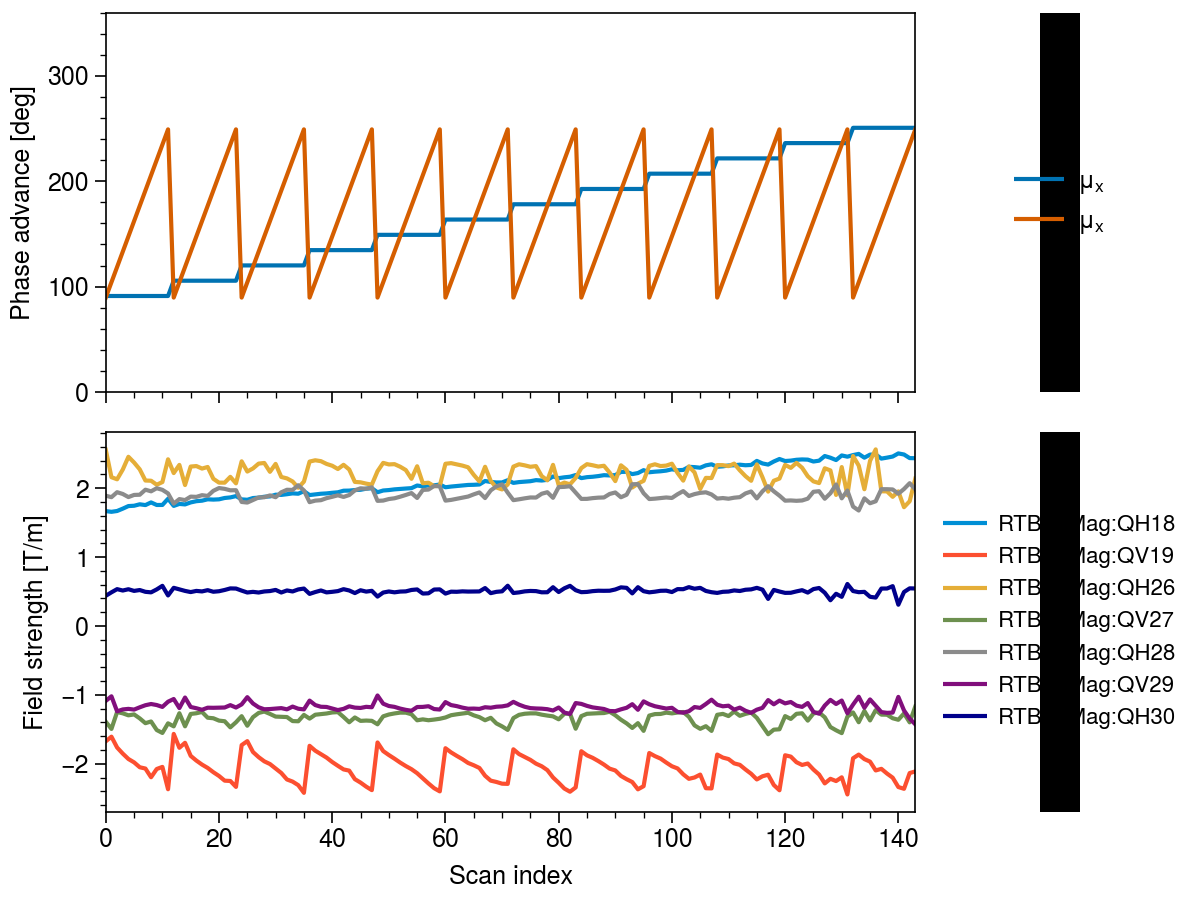

In [12]:
fig, axes = pplt.subplots(nrows=2, figsize=(6., 4.5), spany=False)

for i, label in enumerate([r"$\mu_x$", r"$\mu_y$"]):
    axes[0].plot(np.degrees(phase_adv[:, i]), label=r"$\mu_x$", marker='.', ms=0, alpha=1.0)
axes[0].legend(loc='r', framealpha=0., ncols=1)
axes[0].format(ylabel='Phase advance [deg]', xlabel='Scan index', 
               ylim=(0., 360.0), 
               ygrid=False)

axes[1].format(ylabel='Field strength [T/m]', xlabel='Scan index', ygrid=False, cycle='538')
colors = pplt.Cycle('538').by_key()['color'] + ['darkblue']
for col, color in zip(fields.columns[:-1], colors):
    axes[1].plot(fields.loc[:, col], marker='.', ms=0, color=color)
with pplt.rc.context(legendfontsize=8):
    axes[1].legend(ncols=1, loc='r', framealpha=0.)

plt.savefig('_output/figures/phase_adv_comb.png', **savefig_kws)
plt.show()

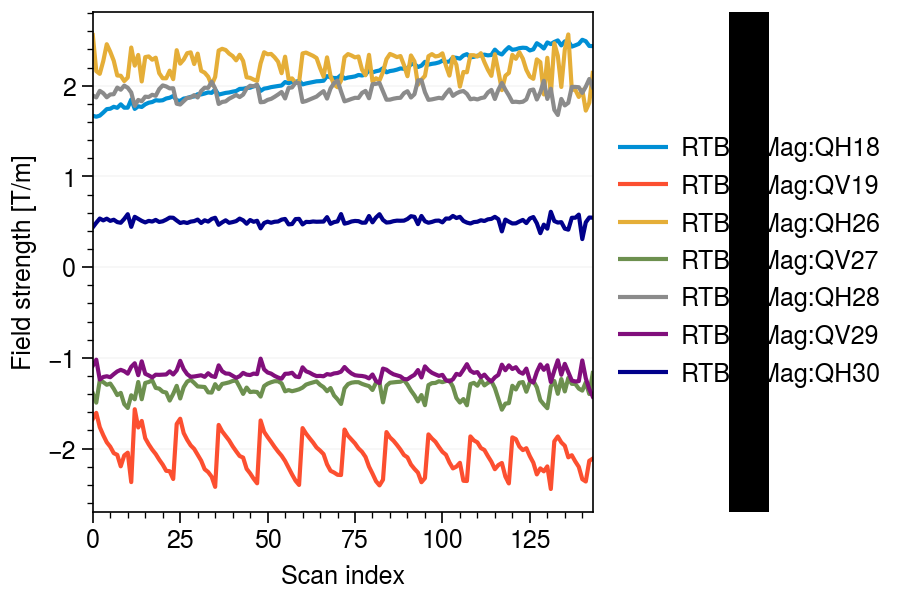

In [13]:
with pplt.rc.context(legendfontsize=9):
    fig, ax = pplt.subplots()
    ax.format(ylabel='Field strength [T/m]', xlabel='Scan index', ygrid=True, cycle='538')
    colors = pplt.Cycle('538').by_key()['color'] + ['darkblue']
    for col, color in zip(fields.columns[:-1], colors):
        ax.plot(fields.loc[:, col], marker='.', ms=0, color=color)
    ax.legend(ncols=1, loc='r', framealpha=0.)
    plt.savefig('_output/figures/fields.png', **savefig_kws)
    plt.show()

### Model Twiss parameters at each node

In [14]:
default_twiss = pd.read_table(join(folder, 'default_twiss.dat'), sep=' ')
i = default_twiss.index[default_twiss['node_id'] == 'RTBT_Mag:QH18'][0]
default_twiss = default_twiss.iloc[:i]
default_twiss

,node_id,mu_x,mu_y,alpha_x,alpha_y,beta_x,beta_y
0,Begin_Of_RTBT1,0.000000,0.000000,-1.252880,0.789988,5.797359,9.995844
1,Ring_Mag:EKick01,0.066754,0.043753,-1.440377,0.721260,6.936607,9.356586
2,Ring_Mag:EKick02,0.126494,0.093993,-1.641614,0.647496,8.335831,8.735170
3,Ring_Mag:EKick03,0.179055,0.150909,-1.854377,0.569508,10.013906,8.151008
4,Ring_Mag:EKick04,0.227461,0.218725,-2.090631,0.482909,12.116596,7.590070
...,...,...,...,...,...,...,...
75,RTBT_Mag:QV17,0.081992,2.018296,0.623418,-2.031575,5.418027,20.063625
76,RTBT_Diag:BPM17,0.186237,2.045688,-0.543109,1.913275,5.484279,19.699387
77,RTBT_Mag:DCV17,0.222107,2.056079,-0.590503,1.865788,5.711811,18.940876
78,RTBT_Diag:BPM18,0.738503,2.516463,-1.742523,0.711507,17.094376,6.366545


In [15]:
rec_node_id = 'RTBT_Diag:BPM17'

In [16]:
idx = default_twiss['node_id'] == rec_node_id
rec_node_id, mu_x, mu_y, alpha_x, alpha_y, beta_x, beta_y = default_twiss.loc[idx].values[0]
print('rec_node_id = {} [m]'.format(rec_node_id))
print('alpha_x = {:.2f} [rad]'.format(alpha_x))
print('alpha_y = {:.2f} [rad]'.format(alpha_y))
print('beta_x = {:.2f} [m/rad]'.format(beta_x))
print('beta_y = {:.2f} [m/rad]'.format(beta_y))

V = ap_utils.V_matrix_4x4_uncoupled(alpha_x, alpha_y, beta_x, beta_y)
Vx = V[:2, :2]
Vy = V[2:, 2:]
print('V =')
print(V)

rec_node_id = RTBT_Diag:BPM17 [m]
alpha_x = -0.54 [rad]
alpha_y = 1.91 [rad]
beta_x = 5.48 [m/rad]
beta_y = 19.70 [m/rad]
V =
[[ 2.34185374  0.          0.          0.        ]
 [ 0.23191428  0.42701215  0.          0.        ]
 [ 0.          0.          4.4383991   0.        ]
 [ 0.          0.         -0.43107317  0.22530646]]


### Transfer matrices 

Load the transfer matrices from this node to the target for each optics setting.

In [ ]:
tmat_filenames = [f for f in filenames if 'tmat' in f]
tmat_filenames = sorted(tmat_filenames, key=lambda f: float(f.split('.')[0].split('_')[-1]))
tmats = []
for filename in tmat_filenames:
    file = open(filename, 'r')
    lines = [line.rstrip() for line in file]
    for line in lines[1:]:
        tokens = line.rstrip().split()
        node_id, tmat_elems = tokens[0], [float(token) for token in tokens[1:]]
        if node_id == rec_node_id:
            tmats.append(np.array(tmat_elems).reshape((4, 4)))
    file.close()

tmats_norm = [np.matmul(M, V) for M in tmats]
tmats_x = [tmat[:2, :2] for tmat in tmats]
tmats_y = [tmat[2:, 2:] for tmat in tmats]
tmats_x_norm = [tmat[:2, :2] for tmat in tmats_norm]
tmats_y_norm = [tmat[2:, 2:] for tmat in tmats_norm]

## Target images 

In [ ]:
image_filenames = [f for f in filenames if 'image' in f]
image_filenames = list(sorted(image_filenames, key=lambda f: int(f.split('.dat')[0].split('_')[-1])))
images = []
for image_filenames in tqdm(image_filenames):
    image = tis.read_file(image_filenames, n_avg='all', make_square=True, thresh=2000)
    images.append(image)

Plot the images.

In [ ]:
# plot_kws = dict(cmap='mono_r')
# ellipse_kws = dict(lw=0.5, alpha=0.75)

# fig, ax = pplt.subplots(figsize=(5.0, 3.0))
# ax.format(
# #     xlabel='x [mm]', ylabel='y [mm]', 
#     aspect=1.0
# )
# ax.axis('off')
# for ellipse in [True]:
#     for sigma in [4.0]:
#         for i, image in enumerate(tqdm(images)):
#             fstr = r'Step {}: $\mu_x = {:.2f}\degree$, $\mu_y = {:.2f}\degree$.'
#             ax.set_title(fstr.format(i, np.degrees(phase_adv[i, 0]), np.degrees(phase_adv[i, 1])))

#             image.filter(sigma)
#             q = ax.pcolormesh(image.xx, image.yy, image.Zf.T, **plot_kws)

#             for patch in ax.patches:
#                 patch.set_visible(False)
#             if ellipse:
#                 mean_x, mean_y, sig_xx, sig_yy, sig_xy = image.estimate_moments(use_filtered=sigma==0.0)
#                 c1, c2, angle = target_image_analysis.rms_ellipse_dims(sig_xx, sig_yy, sig_xy)  
#                 myplt.ellipse(ax, 2 * c1, 2 * c2, angle, center=(mean_x, mean_y), 
#                                    color='red8', **ellipse_kws)                                
                
# #                 Sigma_target = Sigmas_target[i]
# #                 angle, c1, c2 = ba.rms_ellipse_dims(Sigma_target, 'x', 'y')
# #                 myplt.ellipse(ax, 2 * c1, 2 * c2, angle, center=(mean_x, mean_y), 
# #                                   color='blue8', **ellipse_kws)
                
                
#                 ax.legend([Line2D([0], [0], color='red8', **ellipse_kws),
# #                            Line2D([0], [0], color='blue8', **ellipse_kws)
#                           ],
#                           ['image rms', 
# #                            'from ws'
#                           ],
#                           ncols=1, handlelength=1.2, fontsize=6)                
                
#                 r = sig_xy / np.sqrt(sig_xx * sig_yy)
#                 for text in ax.texts:
#                     text.set_visible(False)
#                 ax.annotate('r = {:.2f}'.format(r), xy=(0.02, 0.92), xycoords='axes fraction', color='white',
#                             fontsize='small')
                
# #                 r = Sigma_target[0, 2] / np.sqrt(Sigma_target[0, 0] * Sigma_target[2, 2])
# #                 ax.annotate(r'$r_w$ = {:.2f}'.format(r), xy=(0.02, 0.85), xycoords='axes fraction', color='white',
# #                             fontsize='small')
                
                
#             plt.savefig('_output/figures/target_image_sigma={}_ellipse={}_{}.png'.format(sigma, ellipse, i), **savefig_kws)
#             q.set_visible(False)

## 4D reconstruction from multiple 2D reconstructions

### Form measurement array 

In [ ]:
tmats = np.array(tmats)
tmats = tmats.reshape((steps_per_dim, steps_per_dim, 4, 4))
tmats.shape

Create the measurement array $S$ such that $S_{i, j, k, l}$ gives the intensity at position ($x = x_i$, $y = y_j$) on the screen for the $k$th set of $x$ optics and $l$th set of $y$ optics. We'll need to downsize the image resolution.

In [ ]:
n_bins = 75 
sigma = 4.0 
limit_scaling = 0.65

In [ ]:
S = np.zeros((n_bins, n_bins, len(tmats_x), len(tmats_y)))
scan_index = 0
for k in trange(len(tmats_x)):
    for l in range(len(tmats_y)):        
        if scan_index > len(images) - 1:
            break    
        image = images[scan_index]
        
        # Apply Gaussian filter.
        Z = image.filter(sigma)    
        
        # Change resolution.
        Z = transform.resize(Z, (n_bins, n_bins), anti_aliasing=True)
        screen_xcenters = np.linspace(image.xx[0], image.xx[-1], n_bins)
        screen_ycenters = np.linspace(image.xx[0], image.xx[-1], n_bins)

        # Zoom in while mainting the same resolution.
        screen_xcenters_old = np.copy(screen_xcenters)
        screen_ycenters_old = np.copy(screen_ycenters)
        screen_xcenters = limit_scaling * screen_xcenters_old
        screen_ycenters = limit_scaling * screen_ycenters_old
        screen_xedges = rec.get_bin_edges(screen_xcenters)
        screen_yedges = rec.get_bin_edges(screen_ycenters)        
        Z, _ = rec.transform(Z, np.identity(2), 
                             [screen_xcenters_old, screen_ycenters_old], 
                             [screen_xcenters, screen_ycenters])
        # Save the image.
        S[:, :, k, l] = Z
        scan_index += 1

In [ ]:
fig, axes = pplt.subplots(nrows=S.shape[2], ncols=S.shape[3], figwidth=8, space=0.1)
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        ax.pcolormesh(screen_xcenters, screen_ycenters, S[:, :, i, j].T, 
                      cmap='mono_r', ec='None')
axes.format(xticks=[], yticks=[])
plt.show()

In [ ]:
centers_rec = 2 * [np.linspace(-20.0, 20.0, n_bins)]
centers_meas = [screen_xcenters, screen_ycenters]

In [ ]:
Z = rec.hock4D(S, centers_meas, centers_rec, 
               tmats_x_norm, tmats_y_norm, method='SART', iterations=2)
Z = rec.process(Z, keep_positive=True)

In [ ]:
joint_kws = dict(cmap='mono_r', ec='None')
line_kws = dict(color='red8', alpha=0.5, lw=0.25)
labels = [r"$x_n$", r"$x'_n$", r"$y_n$", r"$y'_n$"]

fig, axes = pplt.subplots(ncols=3, nrows=3, figsize=(5, 5), spanx=False, spany=False)
for j in range(3):
    for i in range(j):
        axes[i, j].axis('off')
for i in range(3):
    for j in range(i + 1):
        ax = axes[i, j]
        _Z = rec.project(Z, [j, i + 1])
        ax.pcolormesh(_Z.T, **joint_kws)

        mean_x, mean_y, sig_xx, sig_yy, sig_xy = tis.estimate_moments(_Z)
        angle, c1, c2 = ba._rms_ellipse_dims(sig_xx, sig_yy, sig_xy)
        myplt.ellipse(ax, 2 * c1, 2 * c2, angle, center=(mean_x, mean_y), **line_kws)
        
    axes[i, 0].set_ylabel([r"x", r"x$\,$'", r"y", r"y$\,$'"][i + 1])
    axes[-1, i].set_xlabel([r"x", r"x$\,$'", r"y", r"y$\,$'"][i])

# plt.suptitle('Reconstruction in normalized phase space')
plt.savefig('_output/figures/Hock.png', **savefig_kws)
plt.show()

### RMS reconstruction from image moments

In [ ]:
sigma = 4.0
cor_coefs = []
moments_image = []
means_image = []
for image in images:
    if sigma > 0.:
        image.filter(sigma)
    mean_x, mean_y, sig_xx, sig_yy, sig_xy = image.estimate_moments(use_filtered=sigma>0.)
    r = sig_xy / np.sqrt(sig_xx * sig_yy)
    cor_coefs.append(r)
    moments_image.append([sig_xx, sig_yy, sig_xy])
    means_image.append([mean_x, mean_y])

In [ ]:
fig, axes = pplt.subplots(nrows=2, figsize=(3.5, 3.5), height_ratios=[1.0, 1.0], spany=False)
axes[0].plot(cor_coefs, marker='.', color='black')
ymax = max(np.abs(axes[0].get_ylim()))
axes[0].format(ylim=(-ymax, ymax), ylabel='x-y cor. coef.')
g1 = axes[1].plot(phase_adv[:, 0])
g2 = axes[1].plot(phase_adv[:, 1])
axes[1].legend([g1, g2], labels=[r"$\mu_x$", r"$\mu_y$"], 
               loc='upper left')
axes[1].format(ylabel='[rad]', ylim=(0.0, 2.0 * np.pi))
axes.format(xlabel='Scan index', ygrid=True, xgrid=False)
plt.savefig('_output/figures/cor_coef.png', **savefig_kws)
plt.show()

In [ ]:
from scdist.measurement import analysis

In [ ]:
Sigma, C = analysis.reconstruct(moments_image, tmats)

In [ ]:
Corr = utils.cov2corr(Sigma)
alpha_x, alpha_y, beta_x, beta_y = ba.twiss2D(Sigma)
eps_x, eps_y, eps_1, eps_2 = ba.emittances(Sigma)
eps_4D = eps_1 * eps_2
coupling_coeff = 1.0 - np.sqrt((eps_1 * eps_2) / (eps_x * eps_y))

In [ ]:
Sigma_std = analysis.to_mat(np.sqrt(C.diagonal()))
eps_x_std, eps_y_std, eps_1_std, eps_2_std = analysis.propagate_emittance_errors(Sigma, C)
alpha_x_std, alpha_y_std, beta_x_std, beta_y_std = analysis.propagate_twiss_errors(Sigma, C)
eps_4D_std = analysis.get_eps4D_std(eps_1, eps_2, eps_1_std, eps_2_std)

In [ ]:
print('Sigma =')
print(Sigma)
print('Standard deviation in Sigma from LLSQ =')
print(Sigma_std)
print('Corr =')
print(Corr)
print('eps_4D = {:.3f} +- {:.3f} [mm^2 mrad^2]'.format(eps_4D, eps_4D_std))
print('eps_1 = {:.3f} +- {:.3f} [mm mrad]'.format(eps_1, eps_1_std))
print('eps_2 = {:.3f} +- {:.3f} [mm mrad]'.format(eps_2, eps_2_std))
print('eps_x = {:.3f} +- {:.3f} [mm mrad]'.format(eps_x, eps_x_std))
print('eps_y = {:.3f} +- {:.3f} [mm mrad]'.format(eps_y, eps_y_std))
print('beta_x = {:.3f} +- {:.3f} [m/rad]'.format(beta_x, beta_x_std))
print('beta_y = {:.3f} +- {:.3f} [m/rad]'.format(beta_y, beta_y_std))
print('alpha_x = {:.3f} +- {:.3f} [m/rad]'.format(alpha_x, alpha_x_std))
print('alpha_y = {:.3f} +- {:.3f} [m/rad]'.format(alpha_y, alpha_y_std))
print('Coupling coefficient = {}'.format(coupling_coeff))

In [ ]:
from scdist.measurement.plotting import reconstruction_lines
from scdist.measurement.plotting import rec_lines

In [ ]:
norm = True
if norm:
    norm_mat = V
else:
    norm_mat = np.identity(4)
norm_mat_inv = np.linalg.inv(norm_mat)
Sigma_n = np.linalg.multi_dot([norm_mat_inv, Sigma, norm_mat_inv.T])

axes = myplt.rms_ellipses(Sigma_n, color='black', pad=0.75, alpha=0.15, fill=True, lw=0, zorder=0)
line_kws = dict(color='pink9', lw=0.5)


Sigma_ws_n = np.linalg.multi_dot([norm_mat_inv, Sigma_ws, norm_mat_inv.T])
myplt.rms_ellipses(Sigma_ws_n, axes=axes, color='black', fill=False)


rec_lines(axes[0, 0], tmats, moments_image, plane='x-xp', norm_mat=norm_mat, **line_kws)
rec_lines(axes[2, 2], tmats, moments_image, plane='y-yp', norm_mat=norm_mat, **line_kws)

if norm:
    labels = [r"$x_n$", r"$x'_n$", r"$y_n$", r"$y'_n$"]
    plt.suptitle('Reconstructed covariance matrix (normalized)')
else:
    labels = [r"$x$ [mm]", r"$x'$  [mrad]", r"$y$ [mm]", r"$y'$ [mrad]"]
    plt.suptitle('Reconstructed covariance matrix')
plt.suptitle('')
for ax, label in zip(axes[:, 0], labels[1:]):
    ax.set_ylabel(label)
for ax, label in zip(axes[-1, :], labels):
    ax.set_xlabel(label)
    
handles = [
    Line2D([0], [0], color='black', alpha=0.15, lw=5),
    Line2D([0], [0], color='black'),
]
axes[0, 1].legend(handles=handles, labels=['images', 'wire-scanners (different beam)'], 
                  loc='upper left', framealpha=0.)
    
plt.savefig('_output/figures/corner.png', **savefig_kws)